<a href="https://colab.research.google.com/github/aced125/Coulomb_matrix_Medium_blogpost/blob/master/Notebook_accompanying_blogpost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab notebook accompanying the Medium blog post 'Teaching AI how to do Quantum Mechanics'

In [0]:
!git clone https://github.com/aced125/Coulomb_matrix_Medium_blogpost

## Imports

In [0]:
import os, pickle, sys, copy, scipy, scipy.io
import numpy as np
from tqdm import trange
np.random.seed(42)

## Helper functions for stochastic data augmentation and activation binarization

In [0]:
class Input():
  
  def __init__(self,X):
    self.step=1.0
    self.noise=1.0
    self.triuind = (np.arange(23)[:,np.newaxis] <= np.arange(23)[np.newaxis,:]).flatten()
    self.max = 0
    for _ in range(10): 
      self.max=np.maximum(self.max,self.realize(X).max(axis=0))
    X = self.expand(self.realize(X))
    self.nbout = X.shape[1]
    self.mean = X.mean(axis=0)
    self.std = (X - self.mean).std()
    
    
    
    
  def realize(self,X):
    def _realize_(x):
      inds = np.argsort(-(x**2).sum(axis=0)**.5+np.random.normal(0,self.noise,x[0].shape))
      x = x[inds,:][:,inds]*1
      x = x.flatten()[self.triuind]
      return x
    return np.array([_realize_(z) for z in X])
      
  def expand(self,X):
    Xexp = []
    for i in range(X.shape[1]):
      for k in np.arange(0,self.max[i]+self.step,self.step):
        Xexp += [np.tanh((X[:,i]-k)/self.step)]
    return np.array(Xexp).T
  
  def normalize(self,X): return (X-self.mean)/self.std
  
  def forward(self,X): return self.normalize(self.expand(self.realize(X))).astype('float32')

In [0]:
class Output():
  
  def __init__(self,T):
    self.tmean = T.mean()
    self.tstd = T.std()
    self.nbinp = 1
    
  def forward(self,X):
    return X*self.tstd + self.tmean

## Grab the downloaded dataset, split it into training (80% of dataset) and testing (20% of dataset) sets

In [0]:
dataset = scipy.io.loadmat('/content/Coulomb_matrix_Medium_blogpost/qm7.mat')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['X'],dataset['T'].reshape(-1))

## Initialize the data augmentation and binarization functions

In [29]:
I,O = Input(X_train),Output(y_train)

print('Dimension of flattened Coulomb matrix:',I.nbout)
print('Output dimension:',O.nbinp)

Dimension of flattened Coulomb matrix: 2089
Output dimension: 1


## Tensorflow time...

In [0]:
import tensorflow as tf

## Two helper functions to shuffle the training data, and get the next batch

In [0]:
def randomize(x,y):
  '''
  Randomizes the order of data samples and corresponding labels
  '''
  perm = np.random.permutation(y.shape[0])
  shuffled_x = x[perm]
  shuffled_y = y[perm]
  return shuffled_x, shuffled_y

def get_next_batch(x,y,start,end):
  x_batch = x[start:end]
  y_batch = y[start:end]
  return x_batch, y_batch

## Reset computational graph

In [0]:
tf.reset_default_graph()

## Hyperparameters (lots of scope for tuning here)

In [0]:
# Hyper-parameters
epochs = 1000             # Total number of training epochs
batch_size = 25        # Training batch size
display_freq = 100      # Frequency of displaying the training results
learning_rate = 0.0001   # The optimization initial learning rate
 

## Helper functions to initialize weights with Xavier initialization, and to create a fully connected layer

In [0]:
def weight_variable(name, shape):
  initer = tf.truncated_normal_initializer(stddev=(1/(shape[0])**.5))
  return tf.get_variable('W_'+name,
                        dtype=tf.float32,
                        shape=shape,
                        initializer=initer)

def bias_variable(name,shape):
  initial = tf.constant(0.,shape=shape,dtype=tf.float32)
  return tf.get_variable('b_'+name,
                        dtype=tf.float32,
                        initializer=initial)

def fc_layer(x,num_units,name,use_sigmoid=True):
  in_dim=x.get_shape().as_list()[1]
  W=weight_variable(name,shape=[in_dim,num_units])
  b=bias_variable(name,[num_units])
  layer=tf.matmul(x,W)
  layer+=b
  if use_sigmoid:
    layer=tf.nn.tanh(layer)
  return layer

## Define placeholder variables

In [0]:
# Defining placeholders

flattened_input_size = I.nbout
n_classes = 1

x = tf.placeholder(tf.float32,shape=[None,flattened_input_size],name='X')
y = tf.placeholder(tf.float32,shape=[None,n_classes],name='Y')

## Write the computational graph (scope for experimentation here)

In [0]:
# Computational Graph

fc1 = fc_layer(x,400,'FC1',use_sigmoid=True)
fc2 = fc_layer(fc1,100,'FC2',use_sigmoid=True)
pre_output = fc_layer(fc2,n_classes,'OUT',use_sigmoid=False)
output = O.forward(pre_output)

## Define loss function and optimizer

In [0]:
# Network predictions
loss = tf.losses.mean_squared_error(labels=y,predictions=output)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate,name='Adam-op').minimize(loss)

## Initialize the session and start training

In [0]:
init=tf.global_variables_initializer()

In [98]:
sess = tf.InteractiveSession()
sess.run(init)
global_step=0

batch_size = 25

num_tr_iter = int(len(X_test) / batch_size)


for epoch in range(epochs):
  print('Training epoch:{}'.format(epoch+1))
  X_train, y_train = randomize(X_train,y_train)
  
  for iteration in trange(num_tr_iter):
    global_step+=1
    
    start = iteration*batch_size
    end = (iteration+1)*batch_size
    
    x_batch, y_batch = get_next_batch(X_train,y_train,start,end)
    
    # Stochastic data augmentation
    x_batch = I.forward(x_batch)
    y_batch = y_batch[:,np.newaxis]

    # Run optimization operation
    feed_dict_batch = {x:x_batch, y:y_batch}
    sess.run(optimizer,feed_dict=feed_dict_batch)
    

  loss_batch = sess.run(loss,feed_dict={x:x_batch,y:y_batch})
  val_loss_batch = sess.run(loss, feed_dict={x:I.forward(X_test),y:y_test[:,np.newaxis]})
  print('\n')
  print("Training MSE={1:.2f}".format(epoch,loss_batch))
  print("Validation MSE={1:.2f}".format(epoch,val_loss_batch))
  print('\n')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
  8%|▊         | 6/71 [00:00<00:01, 57.09it/s]

Training epoch:1


  0%|          | 0/71 [00:00<?, ?it/s]



Training MSE=7754.73
Validation MSE=2528.28


Training epoch:2


KeyboardInterrupt: ignored

## Make a prediction

In [0]:
feed_dict_test = {x: I.forward(X_test), y:y_test[:,np.newaxis]}
predictions = sess.run(output, feed_dict = feed_dict_test)

## View the results

In [79]:
import pandas as pd
np.round(pd.DataFrame(np.array([predictions.reshape(-1),y_test.reshape(-1)]).T),columns = ['Predictions','True'])

,0,1
0,-1911.0,-1909.0
1,-1479.0,-1483.0
2,-1312.0,-1305.0
3,-1728.0,-1712.0
4,-1797.0,-1788.0
5,-1634.0,-1635.0
6,-1138.0,-1155.0
7,-1450.0,-1451.0
8,-1451.0,-1463.0
9,-1512.0,-1513.0


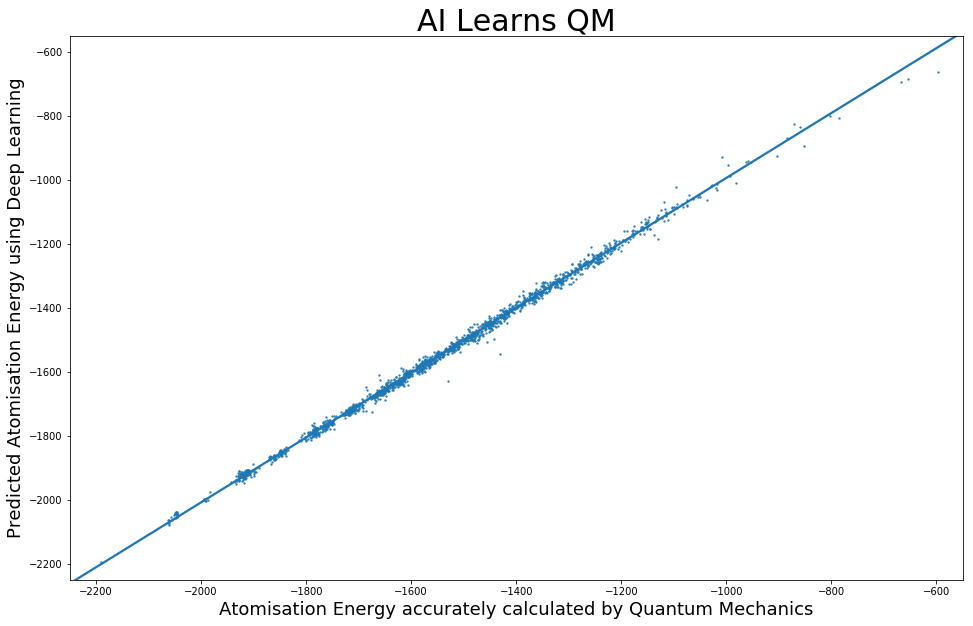

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))

sns.regplot(y_test.reshape(-1),predictions.reshape(-1),
            marker='o',scatter_kws={'s':2})


plt.title('AI Learns QM',fontdict={'fontsize': 30, 'fontweight': 'medium'})
plt.xlim(-2250,-550)
plt.ylim(-2250,-550)
plt.xlabel('Atomisation Energy accurately calculated by Quantum Mechanics',fontdict={'fontsize': 18, 'fontweight': 'medium'})
plt.ylabel('Predicted Atomisation Energy using Deep Learning',fontdict={'fontsize': 18, 'fontweight': 'medium'})
from google.colab import files
plt.savefig("results.png")
files.download("results.png") 
plt.show()
